In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, mean_squared_error

%matplotlib inline

## Pre-transform images to tensors

In [4]:
import torch
from torchvision import transforms
import glob
from PIL import Image
import os
from multiprocessing import Pool

norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
def process_image(img_path_output_size):
    img_path, output_dir, size = img_path_output_size
    basename = os.path.splitext(os.path.basename(img_path))[0]
    out_path = os.path.join(output_dir, f"{basename}.pt")
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    left, top, right, bottom = 20, 20, width - 20, height - 20
    img_cropped = img.crop((left, top, right, bottom))
    img_resized = img_cropped.resize(size, Image.LANCZOS)
    tensor = transforms.ToTensor()(img_resized)
    tensor = norm(tensor)
    torch.save(tensor, out_path)


In [5]:
import concurrent.futures
def save_tensor_images_threaded(input_dir, output_dir, size=(224, 224), num_workers=4):
    os.makedirs(output_dir, exist_ok=True)
    image_files = glob.glob(os.path.join(input_dir, '*.jpg'))
    print(f"Found {len(image_files)} images.")
    args = [(img_path, output_dir, size) for img_path in image_files]
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        results = list(executor.map(process_image, args))
    for res in results[:20]:
        print(res)
    print(f"Finished saving tensors for {len(image_files)} images.")

In [6]:
train_solutions = pd.read_csv('./training_solutions_rev1/training_solutions_rev1.csv')
train_solutions.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [7]:
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

convnext = models.convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
num_classes = len(train_solutions.columns)-1

# Freeze all parameters
for param in convnext.parameters():
    param.requires_grad = False

# Replace the final layer
in_features = convnext.classifier[2].in_features
convnext.classifier[2] = nn.Linear(in_features, num_classes)

# Unfreeze only the last layer of the classifier
for param in convnext.classifier[2].parameters():
    param.requires_grad = True

In [8]:
class GalaxyZooTensorDataset(Dataset):
    def __init__(self, csv_file, tensor_dir):
        self.df = pd.read_csv(csv_file)
        self.tensor_dir = tensor_dir
        self.ids = self.df.iloc[:, 0].values
        self.labels = self.df.iloc[:, 1:].values.astype(np.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        galaxy_id = int(self.ids[idx])
        tensor_path = os.path.join(self.tensor_dir, f"{galaxy_id}.pt")
        image = torch.load(tensor_path)
        labels = self.labels[idx]
        return image, labels

In [9]:
train_dataset_full = GalaxyZooTensorDataset(
    csv_file='./training_solutions_rev1/training_solutions_rev1.csv',
    tensor_dir='./images_training_rev1/images_training_resized'
) # Create the full training dataset

# make a validation set to.. well, validate
total = len(train_dataset_full)
train_size = int(0.8 * total)
val_size = int(0.2 * total)
unused_size = total - (train_size + val_size)

# random_split to partition the dataset into three disjoint subsets
train_subset, val_subset, _ = random_split(train_dataset_full, [train_size, val_size, unused_size])

# creates DataLoaders
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)

In [11]:
criterion = nn.BCEWithLogitsLoss() # tried KLDivLoss first, realized the classes dont all sum to 1.0. fixed
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, convnext.parameters()),
    lr=1e-4
)

In [ ]:
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
convnext = convnext.to(device)
print(f"Device: {device}")

In [ ]:


train_losses = []                          # lists to store training loss per epoch

start_epoch = 0

In [ ]:
# reload a checkpointed model
if os.path.exists("checkpoint.pth"):
    checkpoint = torch.load("checkpoint.pth")
    convnext.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    loss = checkpoint['loss']

In [ ]:
num_epochs = 12                                             # total number of epochs to train
num_epochs += start_epoch

for epoch in range(start_epoch, num_epochs):
    epoch_start = time.time()
    convnext.train()                                       # set model to training mode (affects Dropout/BatchNorm)
    running_loss = 0.0        
    print(f"Epoch {epoch+1}/{num_epochs}")                 # print current epoch number

    batch_times = []
    for batch_idx, (images, labels) in enumerate(train_loader):
        batch_start = time.time()
        images = images.to(device, non_blocking=True)      # move input images to GPU asynchronously
        labels = labels.to(device, non_blocking=True)      # move labels to GPU asynchronously

        optimizer.zero_grad(set_to_none=True)              # reset gradients, set to None for efficiency
        outputs = convnext(images)                         # forward pass through model
        loss = criterion(outputs, labels)                  # compute BCEWithLogitsLoss
        loss.backward()                                    # backpropagate gradients
        optimizer.step()                                   # update model weights

        running_loss += loss.item() * images.size(0)       # accumulate total loss weighted by batch size
        batch_time = time.time() - batch_start
        batch_times.append(batch_time)
        if batch_idx % 10 == 0:
            print(f"  Batch {batch_idx+1}/{len(train_loader)}: Loss={loss.item():.4f}, Time={batch_time:.2f}s")

    avg_train = running_loss / len(train_loader.dataset)   # compute average training loss for the epoch
    train_losses.append(avg_train)                         # store training loss
    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch+1} finished in {epoch_time:.2f}s. Avg batch time: {np.mean(batch_times):.2f}s")

Device: cuda
Epoch 1/12


C:\Users\sbrad\AppData\Local\Temp\ipykernel_11564\1058377620.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(tensor_path)


  Batch 1/385: Loss=0.2985, Time=1.30s
  Batch 11/385: Loss=0.3076, Time=1.06s
  Batch 21/385: Loss=0.2936, Time=1.07s
  Batch 31/385: Loss=0.2947, Time=1.07s
  Batch 41/385: Loss=0.2963, Time=1.07s
  Batch 51/385: Loss=0.2937, Time=1.06s
  Batch 61/385: Loss=0.2930, Time=1.07s
  Batch 71/385: Loss=0.2947, Time=1.07s
  Batch 81/385: Loss=0.3023, Time=1.07s
  Batch 91/385: Loss=0.2955, Time=1.07s
  Batch 101/385: Loss=0.2842, Time=1.07s
  Batch 111/385: Loss=0.2878, Time=1.07s
  Batch 121/385: Loss=0.2766, Time=1.06s
  Batch 131/385: Loss=0.2891, Time=1.09s
  Batch 141/385: Loss=0.2861, Time=1.08s
  Batch 151/385: Loss=0.2910, Time=1.07s
  Batch 161/385: Loss=0.2712, Time=1.07s
  Batch 171/385: Loss=0.2827, Time=1.06s
  Batch 181/385: Loss=0.2738, Time=1.06s
  Batch 191/385: Loss=0.2914, Time=1.06s
  Batch 201/385: Loss=0.2816, Time=1.07s
  Batch 211/385: Loss=0.2902, Time=1.07s
  Batch 221/385: Loss=0.2723, Time=1.07s
  Batch 231/385: Loss=0.2852, Time=1.06s
  Batch 241/385: Loss=0.285

In [16]:
torch.save({
    'epoch': epoch,
    'model_state_dict': convnext.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, "checkpoint.pth")

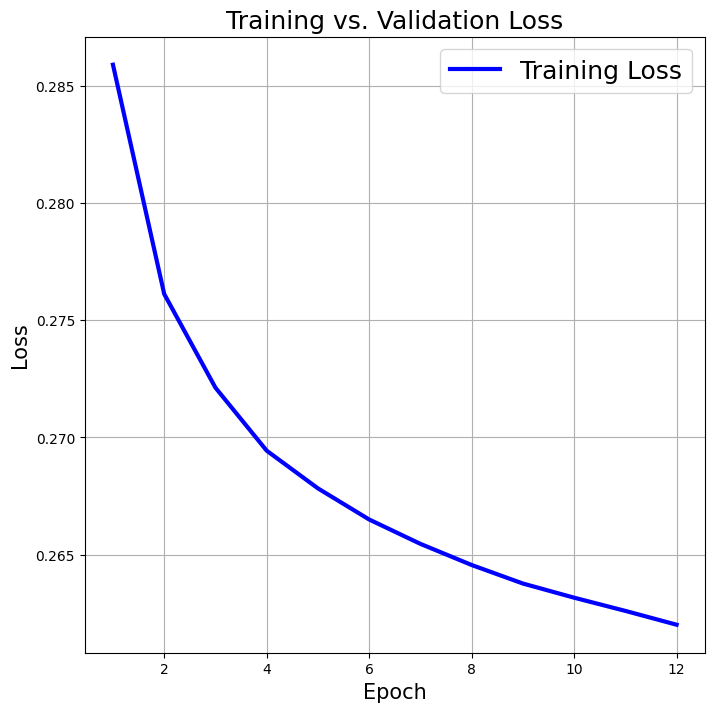

In [17]:
fig = figure(figsize=(8,8), facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color="b", lw=3)
frame.set_xlabel(r"Epoch", fontsize = 15)
frame.set_ylabel(r"Loss", fontsize = 15)
#frame.set_yscale('log')
frame.set_title('Training vs. Validation Loss', fontsize = 18)
frame.legend(prop={'size': 18})
frame.grid()
show()
fig.savefig('loss_curve.png')

In [ ]:
class GalaxyZooTestTensorDataset(Dataset):
    def __init__(self, tensor_dir):
        self.tensor_dir = tensor_dir
        self.tensor_files = sorted([f for f in os.listdir(tensor_dir) if f.endswith('.pt')])

    def __len__(self):
        return len(self.tensor_files)

    def __getitem__(self, idx):
        filename = self.tensor_files[idx]
        tensor_path = os.path.join(self.tensor_dir, filename)
        image = torch.load(tensor_path)
        galaxy_id = os.path.splitext(filename)[0]
        return image, galaxy_id

In [19]:
test_dataset = GalaxyZooTestTensorDataset(tensor_dir='./images_test_rev1/images_test_resized')
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)

In [20]:
convnext.eval()
all_predictions = []
all_galaxy_ids = []

with torch.no_grad():
    for images, galaxy_ids in test_loader:
        images = images.to(device, non_blocking=True)
        outputs = convnext(images) # raw logits
        probs = torch.sigmoid(outputs) # convert logits -> [0, 1] for each output
        all_predictions.append(probs.cpu().numpy())
        all_galaxy_ids.extend(galaxy_ids)

predictions = np.concatenate(all_predictions, axis=0)

C:\Users\sbrad\AppData\Local\Temp\ipykernel_11564\1512712817.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(tensor_path)


In [22]:
columns = ['GalaxyId']
questions = {1: 3, 2: 2, 3: 2, 4: 2, 5: 4, 6: 2, 7: 3, 8: 7, 9: 3, 10: 3, 11: 6}
for q, count in questions.items():
    for i in range(1, count + 1):
        columns.append(f'Class{q}.{i}')

num_pred_columns = sum(questions.values())
assert predictions.shape[1] == num_pred_columns, "Mismatch between predictions and expected class columns."

submission_df = pd.DataFrame(predictions, columns=columns[1:])
submission_df.insert(0, 'GalaxyId', all_galaxy_ids)
print(submission_df.head())
submission_df.to_csv('submission.csv', index=False)

  GalaxyId  Class1.1  Class1.2  Class1.3  Class2.1  Class2.2  Class3.1  \
0   100018  0.404020  0.589156  0.017876  0.059222  0.405589  0.112289   
1   100037  0.231217  0.776061  0.006241  0.412240  0.299036  0.067228   
2   100042  0.552695  0.417210  0.025892  0.145813  0.211409  0.041823   
3   100052  0.616304  0.369067  0.025744  0.070967  0.293345  0.064372   
4   100056  0.193568  0.778442  0.012036  0.661261  0.118471  0.037182   

   Class3.2  Class4.1  Class4.2  ...  Class9.3  Class10.1  Class10.2  \
0  0.272562  0.148955  0.242430  ...  0.011208   0.068138   0.047003   
1  0.266697  0.127268  0.175553  ...  0.096665   0.067758   0.040554   
2  0.210304  0.063192  0.190211  ...  0.051815   0.032249   0.026991   
3  0.278650  0.085713  0.269258  ...  0.012295   0.035507   0.035478   
4  0.096071  0.052233  0.074843  ...  0.336948   0.024916   0.022844   

   Class10.3  Class11.1  Class11.2  Class11.3  Class11.4  Class11.5  Class11.6  
0   0.015486   0.009959   0.059650   0.00